### Baselines

This Notebook shows you to recreate the baseline results from the paper. It is currently set up to produce results for models "nflow", "ctgan", "tvae", "bayesian_network", and "copulagan" for the red wine dataset.

**Imports**

In [38]:
# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns

# Goggle
from goggle.GoggleModel import GoggleModel

# Synthcity
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.plugins import Plugins

**Load data**

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

dataset = "red"
X = pd.read_csv("../data/winequality-red.csv", sep=';')

ind = list(range(len(X.columns)))
ind = [x for x in ind if x != X.columns.get_loc("quality")]

col_list = X.columns[ind]

ct = ColumnTransformer(
    [("scaler", StandardScaler(), col_list)], remainder="passthrough"
)

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5.0
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5.0
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5.0
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6.0
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217796,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294,5.0
1595,-1.390155,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364,6.0
1596,-1.160343,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630,6.0
1597,-1.390155,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308,5.0


**Fit model**

Re-run the notebook with different baseline models to generate all the baseline data from the paper.

In [40]:
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)
gens = Plugins()

baseline_models = ["bayesian_network", "ctgan", "tvae", "nflow"]

gen = gens.get(baseline_models[3])

[2023-09-12T15:03:08.746402+0200][31690][CRITICAL] module disabled: /home/dariusbarsony/anaconda3/envs/goggle_env/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_arf.py
[2023-09-12T15:03:08.748969+0200][31690][CRITICAL] module disabled: /home/dariusbarsony/anaconda3/envs/goggle_env/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_great.py


In [41]:
gen.fit(X_test)

 50%|████▉     | 499/1000 [01:13<01:13,  6.82it/s]


**Evaluate synthetic data**

In [42]:
X_synth = gen.generate(count=X_test.shape[0]).dataframe()
X_synth.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.344389,-0.002097,-1.066204,-0.047696,-0.386936,-0.851219,-0.896517,-0.193845,0.168976,-0.180312,-0.348743,5.0
1,-0.409761,0.940546,0.437941,-0.276739,0.429575,0.987724,-0.225445,-0.194217,0.383799,0.047414,-0.554394,5.0
2,0.218337,0.920921,0.665362,-0.878905,-0.176951,0.702312,0.121635,-0.510364,0.032099,1.192767,0.425758,6.0
3,-0.584555,-0.638278,0.283426,2.466537,0.120998,0.461181,0.895104,0.748898,0.268106,0.384423,-0.996465,5.0
4,0.853750,-1.297016,1.747876,-0.446480,-0.214953,0.814337,-0.875584,-0.754610,-0.091219,0.552311,0.211084,6.0


In [43]:
from synthcity.metrics import eval_statistical
from synthcity.metrics import eval_detection
from synthcity.metrics import eval_performance

def evaluate_synthetic(X_synth, X_test):
    quality_evaluator = eval_statistical.AlphaPrecision()
    qual_res = quality_evaluator.evaluate(X_test, X_synth)
    qual_res = {k: v for (k, v) in qual_res.items() if "naive" in k}
    qual_score = np.mean(list(qual_res.values()))

    xgb_detector = eval_detection.SyntheticDetectionXGB(use_cache=False)
    mlp_detector = eval_detection.SyntheticDetectionMLP(use_cache=False)
    gmm_detector = eval_detection.SyntheticDetectionGMM(use_cache=False)

    xgb_det = xgb_detector.evaluate(X_test, X_synth)
    mlp_det = mlp_detector.evaluate(X_test, X_synth)
    gmm_det = gmm_detector.evaluate(X_test, X_synth)
    det_score = (xgb_det["mean"] + mlp_det["mean"] + gmm_det["mean"]) / 3

    xgb_evaluator = eval_performance.PerformanceEvaluatorXGB()
    linear_evaluator = eval_performance.PerformanceEvaluatorLinear()
    mlp_evaluator = eval_performance.PerformanceEvaluatorMLP()

    xgb_score = xgb_evaluator.evaluate(X_test_loader, X_synth_loader)
    linear_score = linear_evaluator.evaluate(X_test_loader, X_synth_loader)
    mlp_score = mlp_evaluator.evaluate(X_test_loader, X_synth_loader)

    gt_perf = (xgb_score["gt"] + linear_score["gt"] + mlp_score["gt"]) / 3
    synth_perf = (
        xgb_score["syn_ood"] + linear_score["syn_ood"] + mlp_score["syn_ood"]
    ) / 3

    return qual_score, det_score

Quality: 0.595
Detection: 0.633


In [44]:
X_synth_loader = GenericDataLoader(
    X_synth, 
    target_column='quality'
)
X_test_loader = GenericDataLoader(
    X_test, 
    target_column='quality'
)

res = evaluate_synthetic(X_synth_loader, X_test_loader)

print(f"Quality: {res[0]:.3f}")
print(f"Detection: {res[1]:.3f}")


In [45]:
gt_perf - synth_perf 

0.5952280428473596

**Generate TSNE plots**

In [46]:
X_test["label"] = "Original"
X_synth["label"] = "Synthetic"

concat_df = pd.concat([X_test, X_synth], axis=0)
y_data = concat_df["label"]
x_data = concat_df.drop(["label", "quality"], axis=1)

In [47]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, verbose=0, random_state=0)
z = tsne.fit_transform(x_data)
df = pd.DataFrame()
df["y"] = y_data
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

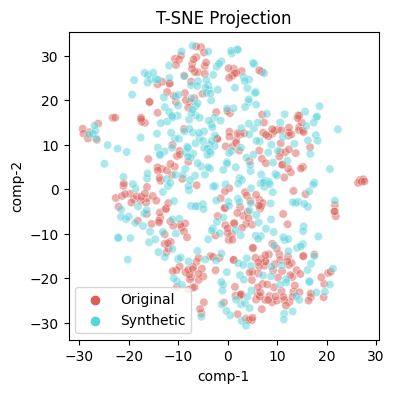

In [48]:
plt.figure(figsize=(4, 4))
sns.scatterplot(
    x="comp-1",
    y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 2),
    alpha=0.5,
    data=df,
).set(title=f"T-SNE Projection")
plt.xlabel("comp-1")
plt.ylabel("comp-2")
plt.legend()

plt.show()